## Phantom Simulation - Flow Motion

In [1]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display
from PIL import Image
from matplotlib.colors import LogNorm
import csv
import os

### 0. Functions

In [2]:
def shift_2d_array(arr_in, rl_shift, ud_shift):
#input: arr_in (input array), rl_shift (shift to right(+ve)/left(-ve) by how many pixels), ud_shift (shift upwards(+ve)/downwards(-ve) by how many pixels)
    rows, cols = arr_in.shape #get array size
    
    shifted_array_vertical = np.roll(arr_in, ud_shift, axis=0) #vertical shift
    
    arr_out = np.roll(shifted_array_vertical, rl_shift, axis=1) #horizontal shift
    
    return np.array(arr_out, dtype = float)

In [3]:
def segment_image(img_in, lower_threshold, upper_threshold):
    
    lower_mask = (img_in >= lower_threshold).astype(np.uint8)
    upper_mask = (img_in <= upper_threshold).astype(np.uint8)
    
    binary_mask = np.logical_and(lower_mask, upper_mask).astype(np.uint8) # Combine the masks to get the final binary mask
    
    segmented_image = img_in * binary_mask # Segment out the pixels with the specified intensity range
    
    non_segmented_image = img_in * (1 - binary_mask)  # Invert the binary mask to get the pixels outside the specified range
    
    return segmented_image, non_segmented_image, binary_mask

In [4]:
def get_phase_modulation(readout_num, TR, cardiac_cycle, phase_oscillation_amplitude):
    t = readout_num * TR #time
    
    #------ sinusoidal model ------
    
#     phase_modulation = phase_oscillation_amplitude * np.sin(2 * np.pi / cardiac_cycle * t)
    
    #------ sinusoidal model ------
    
    #------ more realistic model ------
    
    phase_modulation = (64.5
    - (5.154 * np.cos(2 * np.pi / cardiac_cycle * t) - 10.962 * np.sin(2 * np.pi / cardiac_cycle * t))
    - (5.4516 * np.cos(2 * 2 * np.pi / cardiac_cycle * t) - 1.7574 * np.sin(2 * 2 * np.pi / cardiac_cycle * t))
    - (1.731 * np.cos(3 * 2 * np.pi / cardiac_cycle * t) + 0.846 * np.sin(3 * 2 * np.pi / cardiac_cycle * t))
    - (1.5684 * np.cos(4 * 2 * np.pi / cardiac_cycle * t) + 0.23976 * np.sin(4 * 2 * np.pi / cardiac_cycle * t))
    - (0.50328 * np.cos(5 * 2 * np.pi / cardiac_cycle * t) + 1.0524 * np.sin(5 * 2 * np.pi / cardiac_cycle * t))
    - (0.10014 * np.cos(6 * 2 * np.pi / cardiac_cycle * t) + 0.30504 * np.sin(6 * 2 * np.pi / cardiac_cycle * t))
    - (0.035316 * np.cos(7 * 2 * np.pi / cardiac_cycle * t) + 0.3963 * np.sin(7 * 2 * np.pi / cardiac_cycle * t))
    + (0.16248 * np.cos(8 * 2 * np.pi / cardiac_cycle * t) - 0.17118 * np.sin(8 * 2 * np.pi / cardiac_cycle * t))
    )/33
    
    #------ more realistic model ------
    
    
    
    return phase_modulation

In [5]:
def get_modulated_kspace_line(segment_kspace_line_in, non_segment_kspace_line_in ,phase_modulation):
    
    segment_modulated_kspace_line = (segment_kspace_line_in * np.exp(1j * phase_modulation)).astype(np.complex128)
    modulated_kspace_line = (segment_modulated_kspace_line + non_segment_kspace_line_in).astype(np.complex128)
    return modulated_kspace_line.astype(np.complex128)

In [6]:
def get_mse(img1, img2):
    if img1.shape == img2.shape:
        img1 = img1
        img2 = img2
        mse_map = (img1 - img2) ** 2
    else:
        raise ValueError("Images must have the same dimensions")
    return mse_map

In [7]:
def quantify_artifacts(ground_truth, img_in):
    
    binary_mask = (ground_truth != 0).astype(np.uint8)
    
    gt_cumulative_intensity = np.sum(ground_truth) #cumulative intensity of ground truth
    ip_cumulative_intensity = np.sum(img_in * binary_mask) #in place cumulative intensity of image
    oop_cumulative_intensity = np.sum(img_in * (1 - binary_mask)) #out of place cumulative intensity of image
    
    ip_ratio = ip_cumulative_intensity/gt_cumulative_intensity
    oop_ratio = oop_cumulative_intensity/gt_cumulative_intensity
    
    return ip_ratio, oop_ratio #in place and out of place ratio

### 1. Motion Simulation

3D stack of images, additional time scale, 20 frames of images in 1 cardiac cycle, sample sequencially in k-space, then do inverse fourier transform

Displacement: sinusoidal approximation of motion

#### 1.1 Segmentation

In this part, the Shepp Logan phantom will be segmented into 2 images, with the segmented pixels representing the ones that experience motion, and the rest with no motion.

In [8]:
original_img = sp.shepp_logan([256,256], float)
print(np.unique(original_img))

lower_threshold = np.float64(0.299)
upper_threshold = np.float64(0.301)

lower_mask = (original_img >= lower_threshold).astype(np.uint8)
upper_mask = (original_img <= upper_threshold).astype(np.uint8)

segmented_img, non_segmented_img, binary_mask = segment_image(original_img, lower_threshold, upper_threshold)

[-5.55111512e-17  0.00000000e+00  2.00000000e-01  3.00000000e-01
  1.00000000e+00]


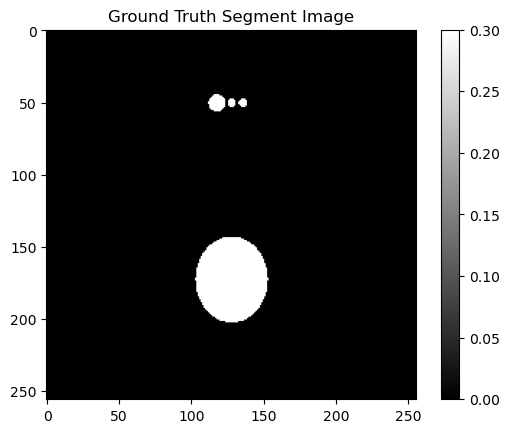

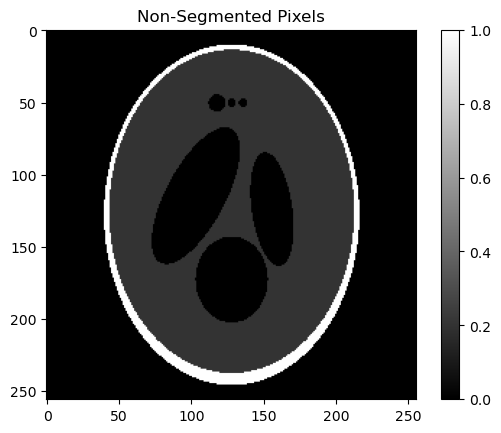

In [9]:
plt.figure()
plt.imshow(segmented_img, cmap='gray')
plt.title('Ground Truth Segment Image')
colorbar = plt.colorbar()

plt.figure()
plt.imshow(non_segmented_img, cmap='gray')
plt.title('Non-Segmented Pixels')
colorbar = plt.colorbar()

(-0.5, 255.5, 255.5, -0.5)

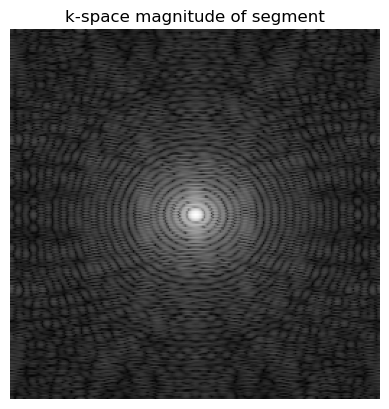

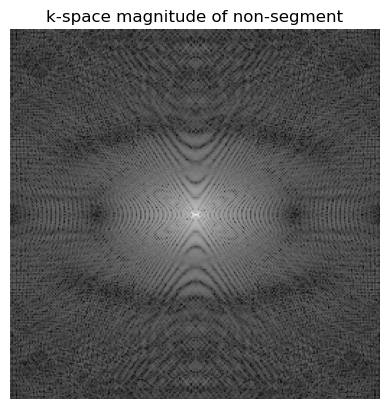

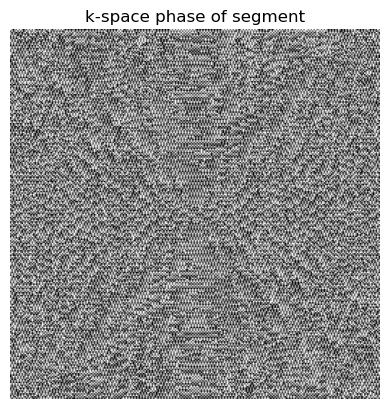

In [10]:
kspace_segmented_img = np.fft.fftshift(np.fft.fft2(segmented_img))
kspace_segmented_img_mag = np.log(np.abs(kspace_segmented_img) + 1)
kspace_segmented_img_phase = np.angle(kspace_segmented_img)

kspace_non_segmented_img = np.fft.fftshift(np.fft.fft2(non_segmented_img))
kspace_non_segmented_img_mag = np.log(np.abs(kspace_non_segmented_img) + 1)
kspace_non_segmented_img_phase = np.angle(kspace_non_segmented_img)

plt.figure()
plt.imshow(kspace_segmented_img_mag, cmap='gray')
plt.title("k-space magnitude of segment")
plt.axis('Off')

plt.figure()
plt.imshow(kspace_non_segmented_img_mag, cmap='gray')
plt.title("k-space magnitude of non-segment")
plt.axis('Off')

plt.figure()
plt.imshow(kspace_segmented_img_phase, cmap='gray')
plt.title("k-space phase of segment")
plt.axis('Off')

#### 1.2 Create Phase Modulation Train

The amplitude of oscillation should be a few pixels/voxels to reflect the pulses in the brain stem.

In [11]:
#Parameters
TR = 6/1000 #second
cardiac_cycle = 1 #second
phase_oscillation_amplitude = np.pi/8 #range: 0 - pi, the bigger, the more artefacts

#### 1.4 Apply reordered sampling scheme to visualise flow motion artefacts without correction

In [12]:
#------Sampling parameters------

TR_spacing = 181 #number of TRs before coming back to the same phase encoding line in the next frame
n_TF = 12 #number of temporal frames that data will be sampled into

#------Sampling parameters------

readout_num = 0 #readout number, starting from zero

Test module: phase modulation train visualisation

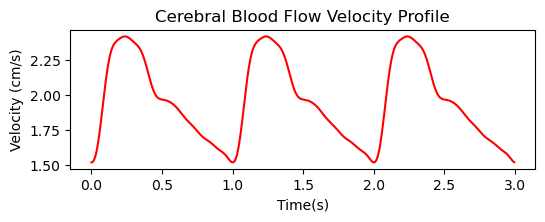

In [13]:
phase_modulation_train = np.array([])
t_train = np.array([])

for i in range(500):
    phase_modulation_test = get_phase_modulation(i, TR, cardiac_cycle, phase_oscillation_amplitude)
    phase_modulation_train = np.append(phase_modulation_train, phase_modulation_test)
    t_train = np.append(t_train, i*TR)

plt.figure(figsize=(6, 1.8))     
plt.plot(t_train, phase_modulation_train, color='r')
plt.xlabel('Time(s)')
plt.ylabel('Velocity (cm/s)')
plt.title('Cerebral Blood Flow Velocity Profile')
plt.show()

In [14]:
#Sample k-space from stack
sampled_kspace = np.zeros((256,256,n_TF), dtype=np.complex128)
sampled_kspace_mag = np.zeros((256,256,n_TF))
sampled_kspace_phase = np.zeros((256,256,n_TF))

sampled_kspace_seg = np.zeros((256,256,n_TF), dtype=np.complex128)
sampled_kspace_seg_mag = np.zeros((256, 256, n_TF))
sampled_kspace_seg_phase = np.zeros((256, 256, n_TF))

phase_modulation_4vis = np.zeros((256, n_TF))

for frame in range(n_TF):
    for row in range(TR_spacing * (np.floor(np.shape(sampled_kspace_seg_phase)[0]/TR_spacing).astype(int) + 1)):
        PE_line = np.remainder(readout_num, TR_spacing).astype(int) + TR_spacing * np.floor(readout_num/(TR_spacing * n_TF)).astype(int)
        sample_into_frame = np.remainder(np.remainder(readout_num, TR_spacing) + np.floor((readout_num/TR_spacing)).astype(int),n_TF).astype(int)

        if PE_line < np.shape(kspace_segmented_img)[0]:
            phase_modulation = get_phase_modulation(readout_num, TR, cardiac_cycle, phase_oscillation_amplitude)
            phase_modulation_4vis[PE_line, sample_into_frame] = phase_modulation
            sampled_kspace[PE_line,:,sample_into_frame] = get_modulated_kspace_line(kspace_segmented_img[PE_line], kspace_non_segmented_img[PE_line] ,phase_modulation)

#             print('PE line '+ str(PE_line) + ' sampled into frame ' + str(sample_into_frame))
        
#         else:
#             print('PE line '+ str(PE_line) + ' discarded for frame ' + str(sample_into_frame))
        
        readout_num += 1

In [15]:
sampled_segment_img = np.zeros((256,256,n_TF))
sampled_img = np.zeros((256,256,n_TF))

for frame in range(n_TF):
    sampled_img[:,:,frame] = np.abs(np.fft.ifftn(sampled_kspace[:,:,frame]))
    sampled_kspace_mag[:,:,frame] = np.log(np.abs(sampled_kspace)[:,:,frame] + 1)
    sampled_kspace_phase[:,:,frame] = np.angle(sampled_kspace[:,:,frame])
    

def update_2d_frame(frame_index):
    plt.imshow(sampled_img[:,:,frame_index], cmap='gray')
    plt.title(f'Frame {frame_index}')
    plt.axis('Off')
    plt.colorbar()
    plt.show()
    
frame_slider = widgets.IntSlider(value=0, min=0, max=n_TF-1, description='Frame') #create slider
widgets.interactive(update_2d_frame, frame_index=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=11), Output()), _dom_classes=('widget-intera…

In [16]:
def update_2d_frame(frame_index):
    plt.imshow(sampled_kspace_mag[:,:,frame_index], cmap='gray')
    plt.title(f'Frame {frame_index}')
    plt.axis('Off')
    plt.colorbar()
    plt.show()
    
frame_slider = widgets.IntSlider(value=0, min=0, max=n_TF-1, description='Frame') #create slider
widgets.interactive(update_2d_frame, frame_index=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=11), Output()), _dom_classes=('widget-intera…

### 4. Periodic Flow Motion Correction

Averaging for different temporal resolutions

In [17]:
avg_kspace = np.mean(sampled_kspace,axis=2)
avg_img = np.abs(np.fft.ifftn(avg_kspace))
# avg_img = np.mean(sampled_segment_img, axis=2)
avg_segment_kspace = np.mean(sampled_kspace_seg, axis=2)
avg_seg_img = np.abs(np.fft.ifftn(avg_segment_kspace))

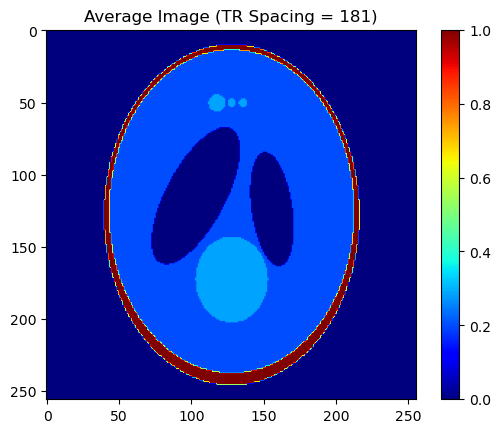

In [18]:
plt.figure()
plt.imshow(avg_img, cmap='jet')
# plt.imshow(avg_img)
plt.title('Average Image (TR Spacing = ' + str(TR_spacing) + ')')
plt.colorbar()

In [19]:
# # Define the directory and file name
# directory = '/Users/ellie/Desktop/FYP/Data'  # Replace with your target directory
# file_name = 'phase_modulation.csv'

# # Ensure the directory exists
# os.makedirs(directory, exist_ok=True)

# # Construct the full file path
# csv_file_path = os.path.join(directory, file_name)

# # Write the header
# with open(csv_file_path, mode='a', newline='') as file:
#     writer = csv.writer(file)
#     headers = ["TR spacing", "Phase modulation"]
#     writer.writerow(headers)

In [20]:
avg_phase_mod = np.mean(phase_modulation_4vis, axis = 1)

phase_modulation_4vis_stretched = np.repeat(phase_modulation_4vis, repeats=12, axis=1)
# with open(csv_file_path, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(np.insert(avg_phase_mod, 0, TR_spacing))

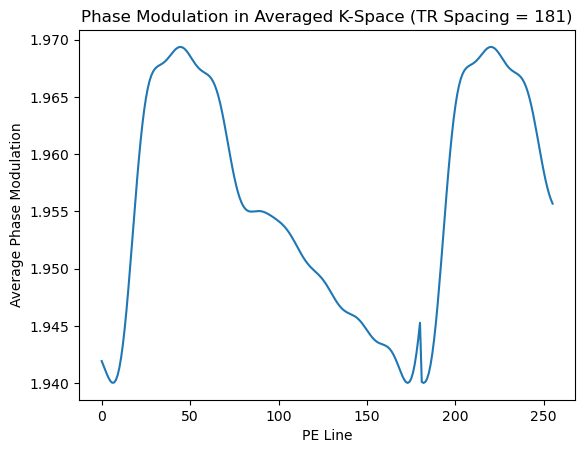

In [21]:
plt.plot(avg_phase_mod)
plt.xlabel('PE Line')
plt.ylabel('Average Phase Modulation')
plt.title('Phase Modulation in Averaged K-Space (TR Spacing = ' + str(TR_spacing) + ')')
plt.show()

Text(0.5, 1.0, '(TR Spacing = 181)')

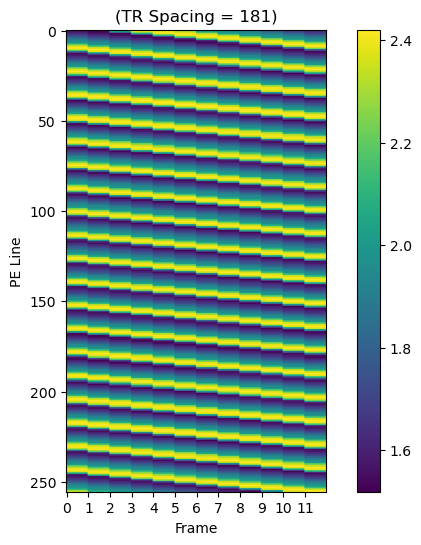

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(phase_modulation_4vis_stretched)
# plt.imshow(phase_modulation_4vis_stretched)
plt.colorbar(cax)
plt.xlabel('Frame')
plt.ylabel('PE Line')


ax.set_xticks(np.arange(n_TF)*12)
ax.set_xticklabels(np.arange(n_TF))
plt.title('(TR Spacing = ' + str(TR_spacing) + ')')

### 5. Visualise Motion Artefacts

In [23]:
mse_map = get_mse(avg_img, original_img)
print(np)

<module 'numpy' from '/Users/ellie/anaconda3/lib/python3.11/site-packages/numpy/__init__.py'>


In [24]:
#MSE map - mask out regions with flow (vessels)

Text(0.5, 1.0, 'MSE Map 1 (TR Spacing = 181)')

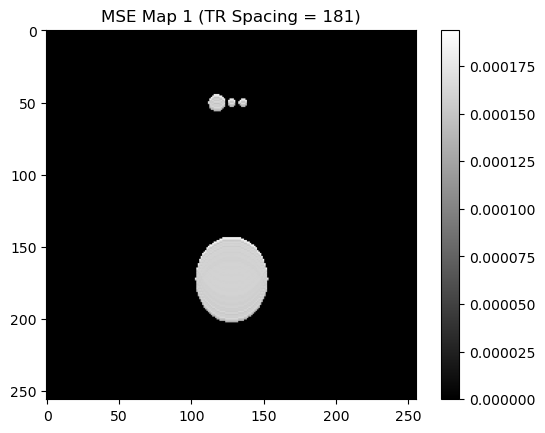

In [25]:
plt.figure()
plt.imshow(mse_map, cmap='gray')
# plt.axis('Off')
plt.colorbar()
plt.title('MSE Map 1 (TR Spacing = ' + str(TR_spacing) + ')')

MSE map masking out segment with motion

In [26]:
mse_seg_wo_flow = mse_map * (1-binary_mask)

Text(0.5, 1.0, 'MSE Map 2 (TR Spacing = 181)')

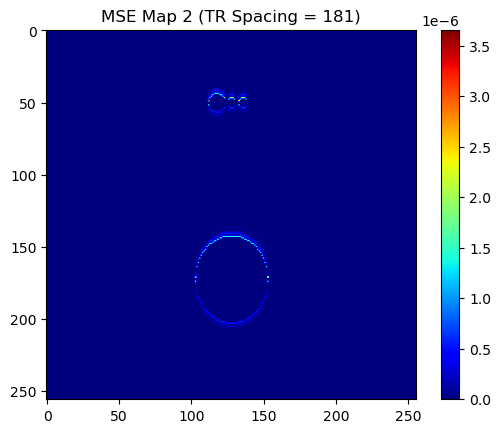

In [29]:
plt.figure()
plt.imshow(mse_seg_wo_flow, cmap='jet')
# plt.axis('Off')
plt.colorbar()
plt.title('MSE Map 2 (TR Spacing = ' + str(TR_spacing) + ')')

In [28]:
MSE_seg_sum = np.sum(mse_seg_wo_flow)
MSE_sum = np.sum(mse_map)
print(MSE_sum)
print(MSE_seg_sum)

0.3978686034022918
0.0002532361475033366
